# Stock Price Prediction using Monte Carlo Simulation
By Luciano Malagola

# DISCLAIMER:
I am NOT a financial advisor. I worked on this project for EDUCATIONAL PURPOSES ONLY, and it SHOULD NOT be considered financial advice in its current state. Always do your own research for investment decisions.

- This script fetches historical stock data from Yahoo Finance based on user input for a specific company or currency exchange
- Analysis is evaluated over a selected range (in years or months).
- The Monte Carlo simulation is used to predict future stock prices based on historical data.
- The simulation results are visualized over a horizon of 7 days.
- Used **pandas** for data manipulation, **numpy** for numerical calculations, **matplotlib** for plotting graphs, and **yfinance** to fetch stock data.
- **relativedelta** was used to easily manipulate date ranges and consider leap years and holidays, to ensure accurate analysis.


First, the required libraries are imported.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re

The following function requests the ticker symbol or "stock abbreviation" of the company or currency exchange that wants to be measured.

In [2]:
def ask_abr():
    while True:
        # Request Ticker Symbol / Abbreviation
        company = input("Input the Ticker Symbol / abbreviation (like TSLA for Tesla or USDEUR=X for USD/EUR)").strip().upper()
        if re.fullmatch(r"[A-Z0-9\.\-\=\^]+", company): # Matches ticker to valid format (may not work for all tickers)
            return company
        else:
            print("Invalid Ticker Symbol, please try again (only A-Z, 0-9, '.', '-', '=', '^').")

The following function lets the user choose between considering years or months for the study period; then, it prompts for a specific amount of time to consider.

In [3]:
def ask_period_type_and_amount(years_available, months_available):
    while True:
        period_type = input(f"Do you want to use years or months for the study period? (Enter 'Y' for years or 'M' for months): ").strip().upper()
        if period_type in ('YEARS', 'YEAR', 'Y'):
            while True:
                amount_input = input(f"How many years do you want to use for the study? (1 to {years_available}): ").strip().upper()
                try:
                    amount = int(amount_input)
                    if 1 <= amount <= years_available:
                        return 'YEARS', amount
                    else:
                        print(f"Please enter a number between 1 and {years_available}.")
                except ValueError:
                    print("Please enter a valid integer.")
        elif period_type in ('MONTHS', 'MONTH', 'M'):
            while True:
                amount_input = input(f"How many months do you want to use for the study? (1 to {months_available}): ").strip().upper()
                try:
                    amount = int(amount_input)
                    if 1 <= amount <= months_available:
                        return 'MONTHS', amount
                    else:
                        print(f"Please enter a number between 1 and {months_available}.")
                except ValueError:
                    print("Please enter a valid integer.")
        else:
            print("Invalid input. Please enter 'Y' for years or 'M' for months")

The following function performs the Monte Carlo simulation.

In [4]:
def monte_carlo_simulation(close, num_simulations, num_days):
    # Calculate daily returns
    daily_returns = close.pct_change().dropna()
    mu = daily_returns.mean()
    sigma = daily_returns.std()
    last_price = close.iloc[-1]

    # Simulation matrix
    simulations = np.zeros((num_days, num_simulations))

    for sim in range(num_simulations):
        price = last_price
        simulations[0, sim] = price  # Set day 0 to last closing price
        for day in range(1, num_days):
            price = price * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
            simulations[day, sim] = price

    return simulations

The next block of code marks the begining of the main function of the program.
After it runs, the historical data of the case study will be displayed.

In [5]:
company = ask_abr()

# Data download (up to 20 years)
end_date = datetime.today()
start_date = end_date - relativedelta(years=20)
print(f"\nDownloading data for {company} from {start_date.date()} to {end_date.date()}...\n")
try:
    data = yf.download(company, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data: {e}\nPlease check your internet connection or try again later.")
    exit()

# Checks if data was downloaded
if data.empty:
    print("No data found for this case study or the ticker symbol is incorrect.")
    exit()
else:
    # Finds the earliest date in the data
    first_date = data.index.min()
    last_date = data.index.max()
    years_available = (last_date - first_date).days // 365
    months_available = (last_date.year - first_date.year) * 12 + (last_date.month - first_date.month)

    print(f"\n\n{company} has historical data from {first_date.date()} to {last_date.date()} ({years_available} full years, {months_available} full months available).")


Input the Ticker Symbol / abbreviation (like TSLA for Tesla or USDEUR=X for USD/EUR)AAPL




/tmp/ipython-input-2622596483.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(company, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



AAPL has historical data from 2005-08-29 to 2025-08-27 (20 full years, 240 full months available).


This block calls for the funcion "ask_period_type_and_amount", promting the user to choose between years and months, and the amount to study. This block also finds the start date for the study.

In [6]:
period_type, amount = ask_period_type_and_amount(years_available, months_available)

# Calculates the start date
if period_type == 'YEARS':
    study_start_date = last_date - relativedelta(years=amount)
else:
    study_start_date = last_date - relativedelta(months=amount)
data = data[data.index >= study_start_date]

Do you want to use years or months for the study period? (Enter 'Y' for years or 'M' for months): Y
How many years do you want to use for the study? (1 to 20): 10


The following section is optional. If you wish to display a section of the downloaded data, uncomment the lines below.

In [7]:
#print("\nDownloaded data:\n")
#print(f"First 5 rows:\n\n{data.head()} \n\n ... ... ... \n\nLast 5 rows:\n\n{data.tail()}\n")  # Show first and last 5 rows
#print(f"\nData contains {data.shape[0]} rows and {data.shape[1]} columns.\n")  # Show data dimensions

The following section is responsible for the handling of MultiIndex Columns, a common occurrence when handling data from yfinance.

In [8]:
    # Handles MultiIndex columns (('Close', 'company')) --- This can be seen by uncommenting the lines above.
    if ('Close', company) in data.columns:
        close = data[('Close', company)]
    elif 'Close' in data.columns:
        close = data['Close']
    else:
        print(f"No 'Close' column found for {company}. Available columns: {data.columns.tolist()}")
        close = None

If the previous section ran well, the 'Close' Price Statistics and a Line Graph of the 'Close' Prices will be displayed after the next block of code runs.

'Close' Price Statistics over selected period 2015-08-27 to 2025-08-27

Historic max: 258.1037
Historic min: 20.6240
Mean: 106.2095
Standard deviation: 69.5745
Last price: 230.4900




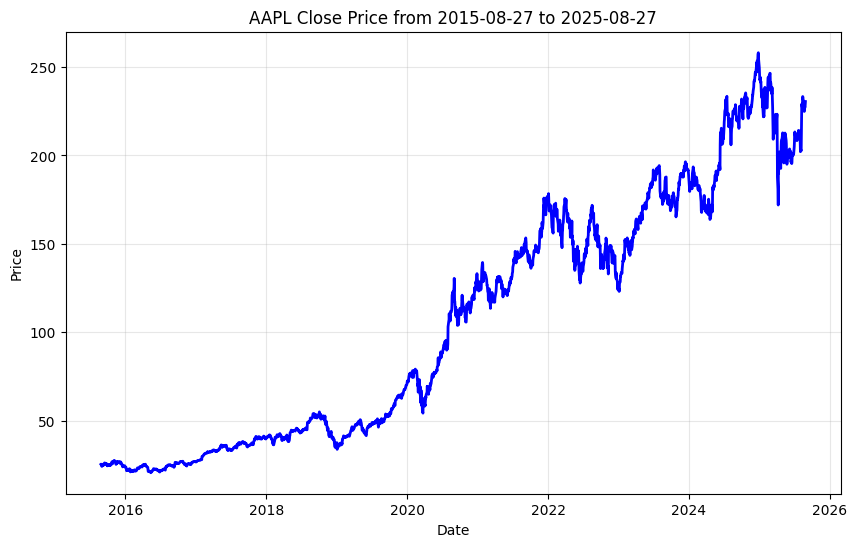

In [9]:
    if close is not None:
        print(f"'Close' Price Statistics over selected period {study_start_date.date()} to {last_date.date()}\n")
        print(f"Historic max: {close.max():.4f}")
        print(f"Historic min: {close.min():.4f}")
        print(f"Mean: {close.mean():.4f}")
        print(f"Standard deviation: {close.std():.4f}")
        print(f"Last price: {close.iloc[-1]:.4f}")
        print("\n")

        # Graph of 'Close' prices using Matplotlib
        plt.figure(figsize=(10, 6))
        plt.plot(close, label='Close Price', color='blue', linewidth=2)
        plt.title(f"{company} Close Price from {study_start_date.date()} to {last_date.date()}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("Cannot perform the analysis without 'Close' price data.")
        exit()

Valuable metrics such as the Daily Mean Return and Daily Standard Deviation are displayed too.

In [10]:
# Daily mean return, std, and beta KPIs
daily_returns = close.pct_change().dropna()
mu = daily_returns.mean()
sigma = daily_returns.std()

print("Daily returns statistics:")
print("\nDaily mean return (μ): {:.4f}".format(mu))
print("Daily standard deviation (σ): {:.4f}".format(sigma))

Daily returns statistics:

Daily mean return (μ): 0.0010
Daily standard deviation (σ): 0.0184


The beta measure is an important metric to display, as it describes the volatility of the price of a stock. If the chosen case study has no beta measure, like a currency exchange, then if will display N/A.

In [11]:
# Beta vs S&P 500
sp500 = yf.download("^GSPC", start=first_date, end=last_date)
if not sp500.empty:
    sp500_close = sp500['Close']
    sp500_returns = sp500_close.pct_change().dropna()
    aligned = pd.concat([daily_returns, sp500_returns], axis=1, join='inner').dropna()
    aligned.columns = ['stock', 'sp500']
    if len(aligned) > 0:
        cov = np.cov(aligned['stock'], aligned['sp500'])[0][1]
        sp500_var = aligned['sp500'].var()
        beta = cov / sp500_var if sp500_var != 0 else np.nan
    else:
        beta = np.nan
else:
    beta = np.nan

print("\n\nEstimated beta (β) vs S&P 500: {}".format("N/A" if np.isnan(beta) else f"{beta:.4f}"))

/tmp/ipython-input-3503317196.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=first_date, end=last_date)
[*********************100%***********************]  1 of 1 completed



Estimated beta (β) vs S&P 500: 1.2080


The following are the variables for the Monte Carlo Simulation: number of simulations and the number of days to analyze.

In [12]:
# Monte Carlo simulation
num_simulations = 1000  # Number of simulated price paths
num_days = 8            # Number of days to simulate
simulations = monte_carlo_simulation(close, num_simulations, num_days)

This block creates the Fan Chart for the Monte Carlo Simulation

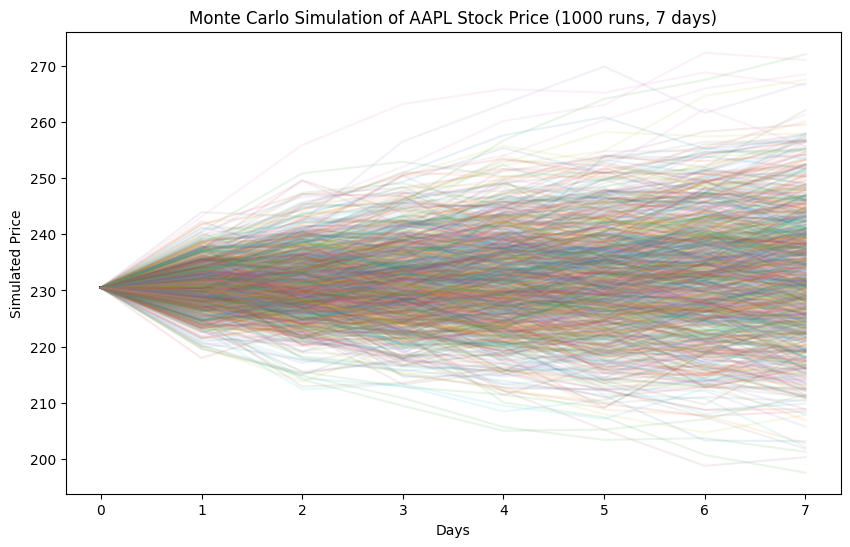

In [13]:
# Plots the simulation results using Matplotlib
plt.figure(figsize=(10,6))
for i in range(num_simulations):
    plt.plot(simulations[:, i], alpha=0.1)
plt.title(f"Monte Carlo Simulation of {company} Stock Price ({num_simulations} runs, {num_days-1} days)")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.show()

The next lines of code print the 95% Confidence Intervals (CI) of the stock's price, as well as their Mean and Median values for each day.

In [14]:
# Calculates and prints the 95% confidence intervals, mean and median for each day
print(f"\n95% confidence intervals, mean and median for each of the {num_days-1} days:")
for day in range(num_days):
    day_prices = simulations[day, :]
    conf_int = np.percentile(day_prices, [2.5, 97.5])
    if day == 0:
        print(f"Day  0 (Last Close): ${conf_int[0]:.4f}")
    else:
        print(f"Day {day:2d}: Interval = [${conf_int[0]:.4f} - ${conf_int[1]:.4f}] / Mean = ${np.mean(day_prices):.4f} / Median = ${np.median(day_prices):.4f}")


95% confidence intervals, mean and median for each of the 7 days:
Day  0 (Last Close): $230.4900
Day  1: Interval = [$223.0256 - $238.6370] / Mean = $230.8393 / Median = $230.6164
Day  2: Interval = [$220.4593 - $243.1647] / Mean = $231.1637 / Median = $230.9518
Day  3: Interval = [$217.7816 - $246.4928] / Mean = $231.4024 / Median = $231.1417
Day  4: Interval = [$215.6861 - $249.1585] / Mean = $231.9136 / Median = $231.7590
Day  5: Interval = [$213.4679 - $250.9938] / Mean = $232.0564 / Median = $231.9005
Day  6: Interval = [$213.1651 - $252.4586] / Mean = $232.7040 / Median = $232.6462
Day  7: Interval = [$211.3552 - $256.4237] / Mean = $233.0476 / Median = $232.7878


Finally, the Mean and Median prices are displayed on a line graph, offering a visual indicator of possible price trajectories in the forecast period.

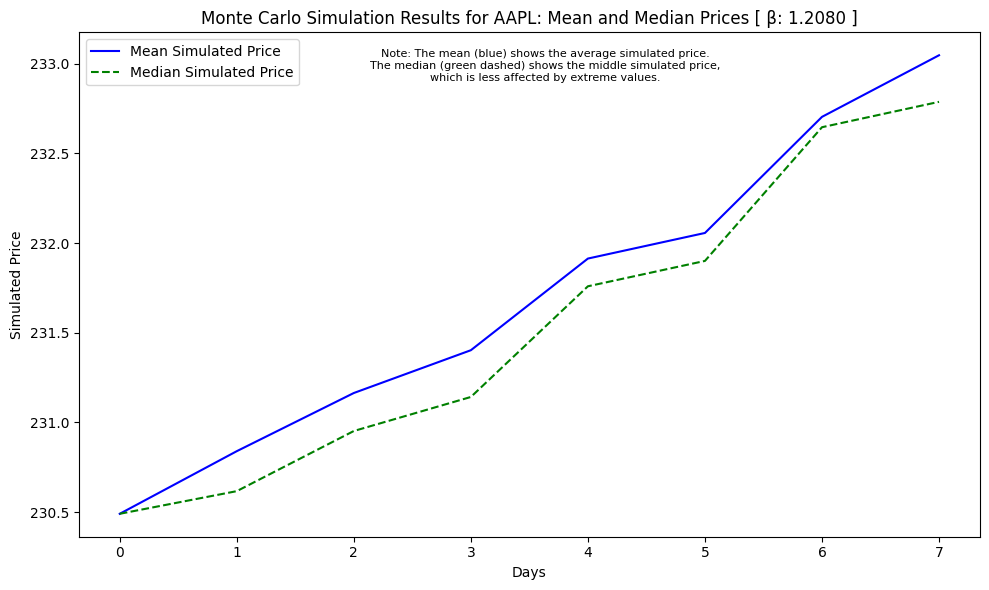

In [15]:
# Plots the Mean and Median Prices using Matplotlib
mean_prices = np.mean(simulations, axis=1)
median_prices = np.median(simulations, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(mean_prices, color='blue', label='Mean Simulated Price')
plt.plot(median_prices, color='green', linestyle='--', label='Median Simulated Price')
plt.title(f"Monte Carlo Simulation Results for {company}: Mean and Median Prices [ β: {beta:.4f} ]")
plt.xlabel("Days")
plt.ylabel("Simulated Price")
plt.legend()
plt.figtext(0.55, 0.86, "Note: The mean (blue) shows the average simulated price.\nThe median (green dashed) shows the middle simulated price,\nwhich is less affected by extreme values.", wrap=True, horizontalalignment='center', fontsize=8)
plt.tight_layout()
plt.show()